# HOI Visualization
* Author: Sungguk Cha
* eMail: sungguk@mindslab.ai

HOI visualization sample script.

In [6]:
# import dependencies
from io import BytesIO
import os
import requests
opj = os.path.join

import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
import torch
import torchvision.transforms as T

import inference
from models import build_model
from models.backbone import build_backbone
from models.deformable_transformer import build_deforamble_transformer
from models.QAHOI import QAHOI

In [7]:
class Args:
  image = 'test.jpg'
  corre_hico_path = './data/hico_20160224_det/annotations/'
  top = 5
  lr = 1e-4
  lr_backbone_names = ['backbone.0']
  lr_backbone = 1e-5
  lr_linear_proj_names = ['reference_points', 'sampling_offsets']
  lr_linear_proj_mult = 1.0
  batch_size = 2
  weight_decay = 1e-4
  epochs = 150
  lr_drop = 120
  lr_drop_epochs = None
  clip_max_norm = 0.1
  nms_thresh = 0.5
  use_checkpoint =  False;
  frozen_weights = None
  two_stage =  False;
  backbone = 'resnet50'
  dilation =  False
  position_embedding = 'sine'
  position_embedding_scale = 2 * np.pi
  num_feature_levels = 4
  enc_layers = 6
  dec_layers = 6
  dim_feedforward = 1024
  hidden_dim = 256
  dropout = 0.1
  nheads = 8
  num_queries = 300
  dec_n_points = 4
  enc_n_points = 4
  masks =  False
  pretrained = ''
  num_verb_classes = 117
  num_obj_classes = 80
  subject_category_id = 0
  no_aux_loss =  True
  set_cost_class = 1
  set_cost_bbox = 2.5
  set_cost_giou = 1
  set_cost_obj_class = 1
  set_cost_verb_class = 1
  mask_loss_coef = 1
  dice_loss_coef = 1
  bbox_loss_coef = 2.5
  giou_loss_coef = 1
  obj_loss_coef = 1
  verb_loss_coef = 1
  eos_coef = 0.1
  dataset_file = 'hico'
  coco_path = './data/coco'
  coco_panoptic_path =  ""
  remove_difficult =  False
  hoi_path = './data/hico_20160224_det'
  output_dir = ''
  device = 'cuda'
  seed = 42
  resume = ''
  start_epoch = 0
  eval =  False;
  eval_extra =  False
  use_nms =  False
  num_workers = 2
    
args = Args()

In [8]:
args.resume = "/DATA2/vision/checkpoints/eyes/hoi/QAHOI/QAHOI_swin_large_384_22k_mul3.pth"
args.corre_hico_path = "/DATA2/vision/data/hico_20160224_det/annotations"
args.backbone = "swin_large_384"
args.num_feature_levels = 3
args.top = 5

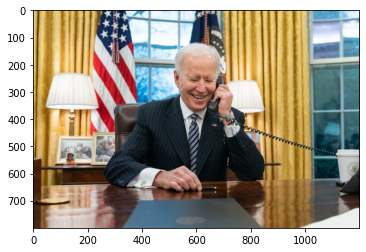

In [4]:
# load sample
image_url = "https://www.lowyinstitute.org/sites/default/files/51130182603_b89f89c42c_o.jpg"
response = requests.get(image_url)
image = Image.open(BytesIO(response.content))
plt.imshow(image)

In [9]:
# load image set
images = list()
imageset_dir = "/DATA2/vision/data/call"
for image_dir in os.listdir(imageset_dir):
    imagedir = opj(imageset_dir, image_dir)
    images.append(imagedir)
print(f"{len(images)} images loaded")

1190 images loaded


In [10]:
# load model
device = torch.device(args.device)

backbone = build_backbone(args)

transformer = build_deforamble_transformer(args)
model = QAHOI(
    backbone,
    transformer,
    num_classes=args.num_obj_classes,
    num_verb_classes=args.num_verb_classes,
    num_queries=args.num_queries,
    num_feature_levels=args.num_feature_levels,
    aux_loss=False
)

checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])

model.to(device)
model.eval()

load pretrained model...


QAHOI(
  (transformer): DeformableTransformer(
    (encoder): DeformableTransformerEncoder(
      (layers): ModuleList(
        (0): DeformableTransformerEncoderLayer(
          (self_attn): MSDeformAttn(
            (sampling_offsets): Linear(in_features=256, out_features=192, bias=True)
            (attention_weights): Linear(in_features=256, out_features=96, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0.1, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout2): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (dropout3): Dropout(p=0.1, inplace=False)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [12]:
# transform image
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [21]:
records = list()
for imagedir in images:
    image = Image.open(imagedir)
    img = transform(image).unsqueeze(0).to(device)
    
    outputs = model(img)

    img_w, img_h = image.size
    target_sizes = torch.tensor([[img_h, img_w]]).to(device)

    postprocess = inference.PostProcessHOI(args.subject_category_id)

    results = postprocess(outputs, target_sizes)

    correct_mat = np.load(os.path.join(args.corre_hico_path, 'corre_hico.npy'))
    preds = inference.prepare_results(results, correct_mat)

    preds = preds[0]

    bboxes, hoi_predictions = preds['predictions'], preds['hoi_prediction']

    scores = np.array([pred['score'] for pred in hoi_predictions])
    score_sort_index = np.argsort(scores)[::-1]
    top_num = min(10, args.top)
    show_index = score_sort_index[:top_num].tolist()

    # bboxes = bboxes[show_index]
    # hoi_predictions = hoi_predictions[show_index]

    top_hoi_predictions = []

    index = 0
    for hoi_prediction in hoi_predictions:
        if index in show_index:
            top_hoi_predictions.append(hoi_prediction)
        index += 1

    sub_boxes = []
    obj_boxes = []
    hoi_categories = []

    for topi in top_hoi_predictions:
        sub_boxes.append(bboxes[topi['subject_id']])
        obj_boxes.append(bboxes[topi['object_id']])
        hoi_categories.append(topi['category_id'])

    obj_ids = list()
    for obj_box in obj_boxes:
        cat = obj_box['category_id']
        if cat not in obj_ids: obj_ids.append(cat)
    record = (imagedir, obj_ids, hoi_categories)
    records.append(record)
    
    #inference.plot_results(image, sub_boxes, obj_boxes, hoi_categories)

In [39]:
print(len(records))
unique_obj = list()
unique_hoi = list()
phone_count = 0
call_counts = dict()
hois = [37, 102, 9, 58]
for hoi in hois:
    call_counts[hoi] = 0
for imagedir, obj_ids, hoi_categories in records:
    for obj_id in obj_ids:
        if obj_id not in unique_obj:
            unique_obj.append(obj_id)
    for hoi_id in set(hoi_categories):
        if hoi_id not in unique_hoi:
            unique_hoi.append(hoi_id)
        if hoi_id in hois:
            call_counts[hoi_id] += 1
    if 77 in obj_ids: phone_count += 1
    # print(imagedir, obj_ids, hoi_categories)

1190


In [29]:
coco_class_dict = {
    1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 
    6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 
    11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 
    17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 
    22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 
    28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 
    35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 
    40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 
    46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 
    51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 
    56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 
    61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 
    67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 
    75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'microwave', 79: 'oven', 
    80: 'toaster', 81: 'sink', 82: 'refrigerator', 84: 'book', 85: 'clock', 
    86: 'vase', 87: 'scissors', 88: 'teddy bear', 89: 'hair drier', 90: 'toothbrush'
}
for obj in unique_obj:
    print(coco_class_dict[obj], end=", ")
print()

cell phone, cup, banana, bottle, wine glass, chair, umbrella, tie, handbag, book, backpack, apple, toothbrush, baseball bat, knife, remote, 


In [32]:
hico_verb_dict = {
    1: 'adjust', 2: 'assemble', 3: 'block', 4: 'blow', 5: 'board', 6: 'break', 7: 'brush_with', 8: 'buy', 
    9: 'carry', 10: 'catch', 11: 'chase', 12: 'check', 13: 'clean', 14: 'control', 15: 'cook', 16: 'cut', 
    17: 'cut_with', 18: 'direct', 19: 'drag', 20: 'dribble', 21: 'drink_with', 22: 'drive', 23: 'dry', 24: 'eat', 
    25: 'eat_at', 26: 'exit', 27: 'feed', 28: 'fill', 29: 'flip', 30: 'flush', 31: 'fly', 32: 'greet', 
    33: 'grind', 34: 'groom', 35: 'herd', 36: 'hit', 37: 'hold', 38: 'hop_on', 39: 'hose', 40: 'hug', 
    41: 'hunt', 42: 'inspect', 43: 'install', 44: 'jump', 45: 'kick', 46: 'kiss', 47: 'lasso', 48: 'launch', 
    49: 'lick', 50: 'lie_on', 51: 'lift', 52: 'light', 53: 'load', 54: 'lose', 55: 'make', 56: 'milk', 
    57: 'move', 58: 'no_interaction', 59: 'open', 60: 'operate', 61: 'pack', 62: 'paint', 63: 'park', 64: 'pay', 
    65: 'peel', 66: 'pet', 67: 'pick', 68: 'pick_up', 69: 'point', 70: 'pour', 71: 'pull', 72: 'push', 
    73: 'race', 74: 'read', 75: 'release', 76: 'repair', 77: 'ride', 78: 'row', 79: 'run', 80: 'sail', 
    81: 'scratch', 82: 'serve', 83: 'set', 84: 'shear', 85: 'sign', 86: 'sip', 87: 'sit_at', 88: 'sit_on', 
    89: 'slide', 90: 'smell', 91: 'spin', 92: 'squeeze', 93: 'stab', 94: 'stand_on', 95: 'stand_under', 96: 'stick', 
    97: 'stir', 98: 'stop_at', 99: 'straddle', 100: 'swing', 101: 'tag', 102: 'talk_on', 103: 'teach', 104: 'text_on', 
    105: 'throw', 106: 'tie', 107: 'toast', 108: 'train', 109: 'turn', 110: 'type_on', 111: 'walk', 112: 'wash', 
    113: 'watch', 114: 'wave', 115: 'wear', 116: 'wield', 117: 'zip'
}
for hoi in unique_hoi:
    print(f"{hoi} {hico_verb_dict[hoi]}", end=", ")
print()

37 hold, 102 talk_on, 9 carry, 74 read, 104 text_on, 21 drink_with, 86 sip, 90 smell, 58 no_interaction, 88 sit_on, 115 wear, 95 stand_under, 107 toast, 28 fill, 71 pull, 1 adjust, 42 inspect, 7 brush_with, 59 open, 116 wield, 


In [40]:
rlen = len(records)
print(f"phone counts {phone_count}/{len(records)} = {phone_count/len(records)}")
for hoi in hois:
    print(f"{hico_verb_dict[hoi]} {call_counts[hoi]}/{rlen} = {call_counts[hoi]/rlen}")

phone counts 1137/1190 = 0.9554621848739496
hold 1184/1190 = 0.9949579831932773
talk_on 1128/1190 = 0.9478991596638655
carry 1141/1190 = 0.9588235294117647
no_interaction 26/1190 = 0.021848739495798318
